We first need to describe where the reaction diffusion takes place. For us ideally we can model an islet in which our cells exist in extracellular space and hormones diffuse from the ECS into cells and from the cytosol into the ECS. Creating this "where" requires you to declare a region, where "i" means intracellular (it assumes that the relevant domains are the plasma membrane or volumes immediately adjacent to on either side which may be a large problem. It even states that "Cell biology models, by contrast, have dynamics spanning a more varied set of locations.") However, we might be able to get by, by creating an intracellular region for each cell type or cell and one extracellular region for all cells.

Concentration increases for ECS when a molecule crosses from inside to outside the membrane (vice versa for ICS) via an NMODL or kschan mechanism. If the species is named ca, then its concentration can be read and set via the NEURON and NMODL range variable `cai`. Looks like for 3D ECS diffusion we will use `rxd.Extracellular()` and will need a separate tutorial. Next we need to specify "who" is diffusing in or out of the cell. We do this with `rxd.Species()` 

Specifying the name argument allows these variables to be linked with range variables. Units considered to be in mM whereas BAD model is in pM. Besides the need to be consistent about units, this has implications for variable step integration which by default has an absolute tolerance of (10^{-3}) or 1 μM. To address this, use atolscale to indicate that the tolerance should be scaled for the corresponding variable; e.g. `atolscale = 1e-7` for pM. Note that `initial` is also a property and can be accessed as any other property. 

Next we must specify how the species interact which is through one or more chemical reactions. Unless `custom_dynamics` is specified, the reaction is considered to be a mass-action reaction. I don't think all of our model is based on mass-action so we will need to look at underlying assumptions. However, for the insulin exocytosis model, all fusion of primed granules assumed to take plae in the microdomain of L type calcium channels. So fusion happens adjacent to the membrane which fits NEURON's assumptions. Typically reactions conserve mass. To model a source or sink, use the non-conservative `rxd.Rate()`. This might be important for replicating results of BAD before extending it. The effects of multiple reactions add together. Rates are proportional to the area between membranes. For example

I have never seen many of the functions being used here so I am going to look line by line to see what this is doing. SWC file structure explanation can be found here http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html.
Looking at the output of `mycell.all`, it appears we have a soma, an axon, and 134 dendrites. Although in the actual swc file it appears that we would have 1507 dendrites.

The swc file follows the following format:
* sample number, structure id, x, y, z, radius, parent sample

So we essentially have a soma, and axon, and then a branched network of dendrites. To access each section, I can use sec.all and index.

Keep boundary conditions in consideration, Initial condition in the ECS need not be a scalar concentration. Suppose we only want to apply the buffer shown above to a sphere in the middle of the ECS, this can be achieved by passing function that takes a node as an argument.

# Test extracellular space: Concentration by Voxel

The mod file we have inserted into our mechanism is releasing calcium at a rate of 1 mA/$cm^{2}$. Lets create a simple cell and a smaller ecs. We really need to see if the location of the cell interacts in any way with the voxels of the extracellular space.

* How big is an islet?

Human islet has average diameter of 130 $u$m with around 200 beta cells. So we can't simulate that many cells. What's an appropriate scale? For now lets use an ECS that is a 100x100x100 $u$m box.

* What is free volume fraction of an islet?

Potentially helpful paper doi: 10.1038/labinvest.2010.124

* Tortuosity?



In [1]:
from neuron import h, units, rxd, load_mechanisms
from neuron.units import mV, ms, um, mM
import math
from matplotlib import pyplot as plt
h.load_file("stdrun.hoc")

In order to figure out how the coordinates of the extracellular space and cells play together, we need to first see how to set positions of the cells. Let's create a sample cell and play around with it.

In [2]:
beta = h.Section(name = "beta")

In [3]:
print("Deault length: " + str(beta.L), "Default diameter: " + str(beta.diam), sep = "\n")

Deault length: 100.0
Default diameter: 500.0


In [4]:
print("Area check: " + str(math.pi * beta.L * beta.diam), "Default area: " + str(beta(0.5).area()), sep="\n")

Area check: 157079.63267948967
Default area: 157079.63267948964


In [5]:
beta.L = beta.diam = 15.5
print("New area: " + str(math.pi * beta.L * beta.diam))

New area: 754.7676350249478


This is what we want our section area to be. Lets look at what our x, y, and z coordinates are by default.

In [6]:
beta.n3d()

0

This shows that there are no 3-d coordinates yet. We can add these using NEURON Vectors. Creating a new cell `beta1` we can see how section length and diameter can also be set through defining a cells 3D points.

In [7]:
beta1 = h.Section(name = "beta1")

In [8]:
beta1.pt3dadd(0,0,0,15.5)
beta1.pt3dadd(7.75,0,0,15.5)
beta1.pt3dadd(15.5,0,0,15.5)

In [9]:
print("Length: " + str(beta1.L))
print("Diameter: " + str(beta1.diam))
print("Area check: " + str(math.pi * beta1.L * beta1.diam))
print("Area: " + str(beta1(0.5).area()))

Length: 15.5
Diameter: 15.5
Area check: 754.7676350249478
Area: 754.7676350249478


Now if we look at the 3D coordinates, we should see that there are 3. One for the 0 end, one for the 0.5 node, and one for the 1 end. The 3D coordinates should be (0,0,0), (7.75,0,0), and (15.5,0,0).

In [10]:

print("Number of 3D coordinates: " + str(beta1.n3d()))
beta1_x = [beta1.x3d(i) for i in range(beta1.n3d())]
beta1_y = [beta1.y3d(i) for i in range(beta1.n3d())]
beta1_z = [beta1.z3d(i) for i in range(beta1.n3d())]
print("X's: " + str(beta1_x))
print("Y's: " + str(beta1_y))
print("Z's: " + str(beta1_z))

Number of 3D coordinates: 3
X's: [0.0, 7.75, 15.5]
Y's: [0.0, 0.0, 0.0]
Z's: [0.0, 0.0, 0.0]


Now lets create a new section `beta2` and set the 3D coordinates using NEURON vectors. Here we just create 4 vectors: one for x, one for y, one for z, and one for diameters.

* Note: Attempting to do this here and in traditional jupyter notebook caused the kernels to die. I am not sure why, but we will skip this method for now.

In [11]:
beta2 = h.Section(name = "beta2")

In [ ]:
xvec = h.Vector(0,7.75,15.5)
yvec = h.Vector(0,0,0)
zvec = h.Vector(0,0,0)
dvec = h.Vector(15.5,15.5,15.5)
h.pt3dadd(xvec, yvec, zvec, dvec, sec = beta2)

One more thing I would like to do before messing with reaction diffusion is see if I can set the 3D coordinates with two points instead of 3.

In [11]:
beta3 = h.Section(name = "beta3")

In [12]:
beta3.pt3dadd(0,0,0,15.5)
beta3.pt3dadd(15.5,0,0,15.5)

At first attempt, this code gave an error because now we need to only use `range(2)` instead of `range(3)`.

In [14]:
print("Number of 3D coordinates: " + str(beta3.n3d()))
beta3_x = [beta3.x3d(i) for i in range(beta3.n3d())]
beta3_y = [beta3.y3d(i) for i in range(beta3.n3d())]
beta3_z = [beta3.z3d(i) for i in range(beta3.n3d())]
print("X's: " + str(beta3_x))
print("Y's: " + str(beta3_y))
print("Z's: " + str(beta3_z))

Number of 3D coordinates: 2
X's: [0.0, 15.5]
Y's: [0.0, 0.0]
Z's: [0.0, 0.0]


Lets check the length, diameter, and area.

In [15]:
print("Length: " + str(beta3.L))
print("Diameter: " + str(beta3.diam))
print("Area check: " + str(math.pi * beta3.L * beta3.diam))
print("Area: " + str(beta3(0.5).area()))

Length: 15.5
Diameter: 15.5
Area check: 754.7676350249478
Area: 754.7676350249478


We can look into orienting the cells at different angles later as I think there is code to do that in some of the tutorials. Lets now create an extracellular space that goes from (0,0,0) to (100,100,100) with a voxel size of 10.

In [16]:
ecs = rxd.Extracellular(0,0,0,100,100,100, dx = 10)

To keep things simple, lets use `beta3` which is the size of a beta cell and insert the mechanism `steady_k` into it. First, lets take a look at `steady_k`:

NEURON {
	SUFFIX steady_k
	USEION k WRITE ik VALENCE 1
	RANGE ik, rate
}

PARAMETER {
    rate    (mA/cm2)
}

INITIAL {
    rate = 1
}
 
ASSIGNED {
    ik     (mA/cm2)
}
 
BREAKPOINT {
    ik = rate
}

So this is a simple mod file that writes a current `ik` and has a consistent current of 1 mA/$cm^2$

In [21]:
beta3.insert('steady_k')

beta3

Now we have to create a `Species` for k.

In [22]:
k = rxd.Species(ecs, d=2.62, name='k', charge=1, initial=3)

RxDException: Species "k" previously defined on region: Extracellular(xlo=0, ylo=0, zlo=0, xhi=100.0, yhi=100.0, zhi=100.0, tortuosity=1.0, volume_fraction=1.0)

Extracellular concentrations at voxels are accessible through `states3d`

In [23]:
k[ecs].states3d

array([[[3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]],

       [[3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]

So what exactly is this representing? It's a 3D vector made up of 10 2D vectors that each consist of 10 1D vectors each with 10 elements. The value is the initial concentration of the Species. So whenever we create an extracellular space and add a Species inside of it, the initial value is set at each voxel by default. We will need to change this. Next lets run a simulatuion and record the concentration at a voxel close to our cell and far away. To record from a voxel, we can either record using the voxels index or we can record by giving the location of the node. First we will use the location of the node and then we will see how to write equivalent statements using locations of nodes and indices inside `states3d`. You can think of each voxel as a node and the nodes can be accessed through the `nodes` property. Thinking about where our section is, we have a section that is 15.5 $\mu m$  long and wide that is centered along the x-axis. Therefore the concentration at the point (10,10,10) should be higher than the concentration at (10,10,20).

In [24]:
print("Number of voxels/nodes: " + str(len(k.nodes)))

Number of voxels/nodes: 1000


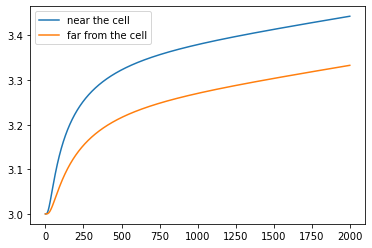

In [25]:
# record from an extracellular nodes given by the x,y,z location
kecs_vec0 = h.Vector()
kecs_vec0.record(k[ecs].node_by_location(10, 10, 10)._ref_value) 

kecs_vec1 = h.Vector()
kecs_vec1.record(k[ecs].node_by_location(10, 10, 20)._ref_value) 

# record the time
t_vec = h.Vector()
t_vec.record(h._ref_t)

# run the simulation
h.finitialize()
h.continuerun(2000 * ms)

# plot the concentations
plt.plot(t_vec, kecs_vec0, label='near the cell')
plt.plot(t_vec, kecs_vec1, label='far from the cell')
plt.legend()

Now I would like to try and find how to make equivalent curves using the index into `states3d` so we know how the two work relative to each other. Now that a simulation has been ran, I wonder if `states3d` will still show the same concentrations.

In [50]:
k[ecs].states3d

array([[[4.63790476, 3.76821686, 3.44748277, 3.29990678, 3.21962082,
         3.17104419, 3.14003333, 3.12014859, 3.10819196, 3.1025548 ],
        [3.76821686, 3.53478833, 3.37120845, 3.26967093, 3.20547982,
         3.16350835, 3.13557157, 3.11723442, 3.10606241, 3.10075943],
        [3.44748277, 3.37120845, 3.2922834 , 3.22984662, 3.18395094,
         3.15100963, 3.12778143, 3.11198243, 3.10214935, 3.09742852],
        [3.29990678, 3.26967093, 3.22984662, 3.19226747, 3.16098316,
         3.13651115, 3.11821521, 3.10527793, 3.09702603, 3.09301038],
        [3.21962082, 3.20547982, 3.18395094, 3.16098316, 3.13993247,
         3.12222889, 3.1082751 , 3.0980352 , 3.09134237, 3.08804005],
        [3.17104419, 3.16350835, 3.15100963, 3.13651115, 3.12222889,
         3.10949571, 3.09899691, 3.09103327, 3.08570981, 3.08304873],
        [3.14003333, 3.13557157, 3.12778143, 3.11821521, 3.1082751 ,
         3.09899691, 3.0910575 , 3.08486283, 3.08063954, 3.07850381],
        [3.12014859, 3.1172

Since it shows the current concentrations after the simulation, we can use this to see how node-by-location interacts with node-by-index. Documentation says we define the left-lower-back corner, a step size for x, y, and z and then a right-top-front corner. So my initial guess is the first 2D vector is the bottom "layer" of our cube and then we layer up. Let's confine ourselves to the first layer at first for simplicity since it has the only value that is greater than 3 in our ECS.

In [55]:
k[ecs].states3d[0]

array([[4.63790476, 3.76821686, 3.44748277, 3.29990678, 3.21962082,
        3.17104419, 3.14003333, 3.12014859, 3.10819196, 3.1025548 ],
       [3.76821686, 3.53478833, 3.37120845, 3.26967093, 3.20547982,
        3.16350835, 3.13557157, 3.11723442, 3.10606241, 3.10075943],
       [3.44748277, 3.37120845, 3.2922834 , 3.22984662, 3.18395094,
        3.15100963, 3.12778143, 3.11198243, 3.10214935, 3.09742852],
       [3.29990678, 3.26967093, 3.22984662, 3.19226747, 3.16098316,
        3.13651115, 3.11821521, 3.10527793, 3.09702603, 3.09301038],
       [3.21962082, 3.20547982, 3.18395094, 3.16098316, 3.13993247,
        3.12222889, 3.1082751 , 3.0980352 , 3.09134237, 3.08804005],
       [3.17104419, 3.16350835, 3.15100963, 3.13651115, 3.12222889,
        3.10949571, 3.09899691, 3.09103327, 3.08570981, 3.08304873],
       [3.14003333, 3.13557157, 3.12778143, 3.11821521, 3.1082751 ,
        3.09899691, 3.0910575 , 3.08486283, 3.08063954, 3.07850381],
       [3.12014859, 3.11723442, 3.1119824

In [26]:
print(k[ecs].node_by_location(0,0,0)._ref_value)
print(k[ecs].node_by_location(0,10,0)._ref_value)
print(k[ecs].node_by_location(0,20,0)._ref_value)
print(k[ecs].node_by_location(0,30,0)._ref_value)
print(k[ecs].node_by_location(0,40,0)._ref_value)

<pointer to hoc scalar 4.6379>
<pointer to hoc scalar 3.76822>
<pointer to hoc scalar 3.44748>
<pointer to hoc scalar 3.29991>
<pointer to hoc scalar 3.21962>


We can see that as we step from voxel to voxel in the y direction that we are traversing through the first 1D array in our matrix above. 

In [28]:
print(k[ecs].node_by_location(0,0,0)._ref_value)
print(k[ecs].node_by_location(10,0,0)._ref_value)
print(k[ecs].node_by_location(20,0,0)._ref_value)
print(k[ecs].node_by_location(30,0,0)._ref_value)
print(k[ecs].node_by_location(40,0,0)._ref_value)

<pointer to hoc scalar 4.6379>
<pointer to hoc scalar 3.80846>
<pointer to hoc scalar 3.47949>
<pointer to hoc scalar 3.32232>
<pointer to hoc scalar 3.23584>


As we step through the voxels in the x direction, we can see that we traverse the first elements of each of the individual 1D arrays. So it appears that each of the 2D arrays inside states 3D is an xy slice and each 1D array inside a slice is at a constant x value and increasing values of y. So what would nodes (10,10,10) and (10,10,20) be in terms of indices then? 

In [31]:
print(k[ecs].node_by_location(0,0,0)._ref_value, k[ecs].node_by_ijk(0,0,0)._ref_value, sep = "=")
print(k[ecs].node_by_location(10,0,0)._ref_value, k[ecs].node_by_ijk(1,0,0)._ref_value, sep = "=")
print(k[ecs].node_by_location(20,0,0)._ref_value, k[ecs].node_by_ijk(2,0,0)._ref_value, sep = "=")
print(k[ecs].node_by_location(30,0,0)._ref_value, k[ecs].node_by_ijk(3,0,0)._ref_value, sep = "=")
print(k[ecs].node_by_location(40,0,0)._ref_value, k[ecs].node_by_ijk(4,0,0)._ref_value, sep = "=")
print(k[ecs].node_by_location(0,10,0)._ref_value, k[ecs].node_by_ijk(0,1,0)._ref_value, sep = "=")
print(k[ecs].node_by_location(0,20,0)._ref_value, k[ecs].node_by_ijk(0,2,0)._ref_value, sep = "=")
print(k[ecs].node_by_location(0,30,0)._ref_value, k[ecs].node_by_ijk(0,3,0)._ref_value, sep = "=")
print(k[ecs].node_by_location(0,40,0)._ref_value, k[ecs].node_by_ijk(0,4,0)._ref_value, sep = "=")

<pointer to hoc scalar 4.6379>=<pointer to hoc scalar 4.6379>
<pointer to hoc scalar 3.80846>=<pointer to hoc scalar 3.80846>
<pointer to hoc scalar 3.47949>=<pointer to hoc scalar 3.47949>
<pointer to hoc scalar 3.32232>=<pointer to hoc scalar 3.32232>
<pointer to hoc scalar 3.23584>=<pointer to hoc scalar 3.23584>
<pointer to hoc scalar 3.76822>=<pointer to hoc scalar 3.76822>
<pointer to hoc scalar 3.44748>=<pointer to hoc scalar 3.44748>
<pointer to hoc scalar 3.29991>=<pointer to hoc scalar 3.29991>
<pointer to hoc scalar 3.21962>=<pointer to hoc scalar 3.21962>


So say we have a node that is at a location (x,y,z) and we want to find its indices, we would simply do (x/dx, y/dy, z/dz). We can see if we do this, we get the same plot as above.

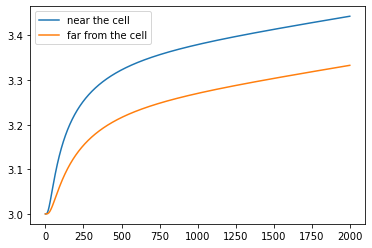

In [33]:
kecs_vec2 = h.Vector()
kecs_vec2.record(k[ecs].node_by_ijk(1,1,1)._ref_value)

kecs_vec3 = h.Vector()
kecs_vec3.record(k[ecs].node_by_ijk(1,1,2)._ref_value)

# record the time
t_vec = h.Vector()
t_vec.record(h._ref_t)

# run the simulation
h.finitialize()
h.continuerun(2000 * ms)

# plot the concentations
plt.plot(t_vec, kecs_vec2, label='near the cell')
plt.plot(t_vec, kecs_vec3, label='far from the cell')
plt.legend()

# Create sink for hormones that matches BAD model

In the BAD model, the hormones are assumed to accumulate and clear from a single, well-mixed space. In NEURON Rxd, reactions conserve mass so we must use `rxd.Rate`. It seems that we can use three `rxd.Rate` statement to describe the production and degredation of each hormone in the space. Let's start with a new cell, a new ecs, and this time we can edit the mechanism `one` to secrete hormones into the space. First we will start with a NEURON `Region` and then will try with ECS. 

In order to get the Rxd simulation to work I added the following lines to `one.mod`

	: Temporary Rxd variables
	USEION I WRITE iI VALENCE 0
	USEION G WRITE iG VALENCE 0
	USEION S WRITE iS VALENCE 0
	
	RANGE iI, iG, iS

I then commented out the equations for I', S', and G'. I made iI, iG, and iS RANGE variables. You will see below that we are having wild oscillations as we did before when trying to get one.mod to work. This time however, it is not caused by errors in initialized values. Looking at the lists that hold the concentrations, what happens is the concentrations decrease quickly (besides sst) and then once they become extremely small the oscillations come in. I set the tolerance for Species to be 1e-10 at first, then 1e-15, and then 1e-20. Decreasing the tolerance increased the amount of timesteps that passed before the wild oscillations started but it did not prevent them. The next thing I want to look into is the values of JIS, JGS, and JSS because I know they are extremely small (on the order of 1e-14).

In [ ]:
! nrnivmodl
load_mechanisms("C:/Users/rober/OneDrive - University of Florida/Documents/Research/Pancreatic_islet_model")

Error: Session cannot generate requests

In [4]:
beta4 = h.Section(name = "beta4")

In [5]:
beta4.insert("one")

beta4

In [4]:
# Create region
sink = rxd.Region(beta4, nrn_region = 'o', geometry = None)

# Create Species
G = rxd.Species(regions = sink, d = 0, name = "G", initial = 31.73727470720019, charge = 0, atolscale=1e-11)
I = rxd.Species(regions = sink, d = 0, name = "I", initial = 48.04298494148047, charge = 0, atolscale=1e-10)
S = rxd.Species(regions = sink, d = 0, name = "S", initial = 18.71318922819339, charge = 0, atolscale=1e-15)

# Set volume of sink and clearance rates of hormones from the sink
# These variables aren't known emperically and were optimized for the focus of the BAD model paper
sink_v = 1e-13
I_sink_clear = 2000
G_sink_clear = 150
S_sink_clear = 0.003

# Set Reactions
I_secretion_and_degredation = rxd.Rate(I, beta4(0.5).one.JIS/sink_v - I_sink_clear * I)
G_secretion_and_degredation = rxd.Rate(G, beta4(0.5).one.JGS/sink_v - G_sink_clear * G)
S_secretion_and_degredation = rxd.Rate(S, beta4(0.5).one.JSS/sink_v - S_sink_clear * S)

Below the initial concentrations are printed to confirm they are set properly.

In [5]:
print(I.nodes[0].concentration, G.nodes[0].concentration, S.nodes[0].concentration, sep = "\n")

48.04298494148047
31.73727470720019
18.71318922819339


In [9]:
beta4(0.5).one._ref_JIS

<pointer to hoc scalar 0>

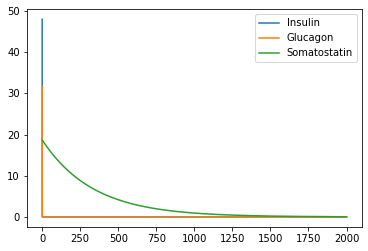

In [6]:
h.CVode().active(False)
simulation_time = 2000
dt = 0.025
time_steps = int(simulation_time/dt)
I_conc = I.nodes.concentration
G_conc = G.nodes.concentration
S_conc = S.nodes.concentration
t_vec = h.Vector()
t_vec.record(h._ref_t)
JIS_vec = h.Vector()
JIS_vec.record(beta4(0.5).one._ref_JIS)
JGS_vec = h.Vector()
JGS_vec.record(beta4(0.5).one._ref_JGS)
JSS_vec = h.Vector()
JSS_vec.record(beta4(0.5).one._ref_JSS)

h.finitialize()

for time_step in range(time_steps):
    h.fadvance()
    I_conc.append(I.nodes.concentration[0])
    G_conc.append(G.nodes.concentration[0])
    S_conc.append(S.nodes.concentration[0])


plt.plot(t_vec, I_conc, label = "Insulin")
plt.plot(t_vec, G_conc, label = "Glucagon")
plt.plot(t_vec, S_conc, label = "Somatostatin")
plt.legend()

In [7]:
print(max(I_conc), min(I_conc))
print(max(G_conc), min(G_conc))
print(max(S_conc), min(S_conc))

48.04298494148047 -1.474723325814308e-19
31.73727470720019 -1.1445248744736164e-19
18.71318922819339 0.04639579588971742


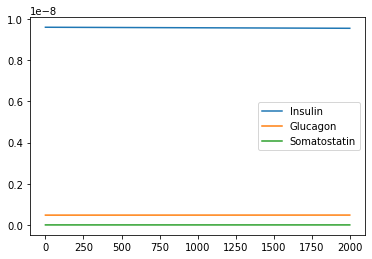

In [13]:
plt.plot(t_vec, JIS_vec, label = "Insulin")
plt.plot(t_vec, JGS_vec, label = "Glucagon")
plt.plot(t_vec, JSS_vec, label = "Somatostatin")
plt.legend()

In [17]:
for i in range(10):
    print(JSS_vec[i])

4.412501110619871e-14
4.412501110619871e-14
4.401979274237234e-14
4.391293919029411e-14
4.380451369471204e-14
4.3694576372575665e-14
4.35831843974379e-14
4.34703921727621e-14
4.335625149478399e-14
4.32408117055455e-14


# Try sample k mod file with 0 valence rather than 1

In [ ]:
beta_0 = h.Section(name = "beta_0")

Error: Session cannot generate requests